In [1]:
import transformers
from transformers import ViTConfig, ViTModel

/home/chenningcong/Desktop/Deeplearning/deep/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from datasets import load_dataset

# load cifar10 (only small portion for demonstration purposes) 
train_ds, test_ds = load_dataset('cifar10', split=['train', 'test'])
id2label = {id:label for id, label in enumerate(train_ds.features['label'].names)}
label2id = {label:id for id,label in id2label.items()}

In [3]:
train_ds,train_ds.features

(Dataset({
     features: ['img', 'label'],
     num_rows: 50000
 }),
 {'img': Image(decode=True, id=None),
  'label': ClassLabel(names=['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'], id=None)})

In [4]:
import autoaugment

In [5]:
autoaugment.CIFAR10Policy()

AutoAugment CIFAR10 Policy

In [8]:
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize, 
                                    RandomHorizontalFlip,
                                    RandomResizedCrop, 
                                    Resize, 
                                    ToTensor)

image_mean, image_std = (0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)
size = 32
        
normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            RandomHorizontalFlip(),
            autoaugment.CIFAR10Policy(),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['img']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['img']]
    return examples
# Set the transforms
train_ds.set_transform(train_transforms)
test_ds.set_transform(val_transforms)

In [9]:
train_ds[0]

{'img': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=32x32>,
 'label': 0,
 'pixel_values': tensor([[[ 0.8366,  0.8366,  0.8366,  ...,  0.7096,  0.6778,  0.6302],
          [ 0.8683,  0.8525,  0.8683,  ...,  0.7572,  0.7255,  0.6778],
          [ 0.8207,  0.8207,  0.8366,  ...,  0.7255,  0.6937,  0.6620],
          ...,
          [-0.2113, -0.1954, -0.1795,  ..., -0.4018, -0.4335, -0.3859],
          [-0.2113, -0.2113, -0.1954,  ..., -0.3700, -0.3700, -0.3700],
          [-0.3542, -0.4018, -0.3542,  ..., -0.5288, -0.5129, -0.5447]],
 
         [[ 0.8560,  0.8560,  0.8560,  ...,  0.7268,  0.6946,  0.6462],
          [ 0.8882,  0.8721,  0.8882,  ...,  0.7753,  0.7430,  0.6946],
          [ 0.8398,  0.8398,  0.8560,  ...,  0.7430,  0.7107,  0.6784],
          ...,
          [-0.2576, -0.2253, -0.2092,  ..., -0.4190, -0.4674, -0.4512],
          [-0.3383, -0.3221, -0.3221,  ..., -0.4512, -0.4835, -0.4997],
          [-0.4351, -0.4835, -0.4512,  ..., -0.6288, -0.5965, -0.6288]],
 
  

In [10]:
from torch.utils.data import DataLoader
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [11]:
from transformers import ViTForImageClassification
#{"hidden_size": 128, "hidden_act": "gelu",  "num_attention_heads": 2, "num_hidden_layers": 2, "intermediate_size": 512, "attention_probs_dropout_prob": 0.1}

vit_config = transformers.ViTConfig(
        hidden_size=384,
        num_hidden_layers=7,
        num_attention_heads=12,
        intermediate_size=384,
        hidden_act="gelu",
        hidden_dropout_prob=0.1,
        attention_probs_dropout_prob=0.1,
        initializer_range=0.02,
        layer_norm_eps=1e-12,
        image_size=32,
        patch_size=4,
        num_channels=3,
        qkv_bias=True,
 num_labels=len(id2label),
    id2label=id2label,
    label2id=label2id)
model = ViTForImageClassification(vit_config,
   )
sum([p.numel() for p in  model.parameters()])

6268810

In [12]:
from transformers import TrainingArguments, Trainer

metric_name = "accuracy"

args = TrainingArguments(
    f"test-cifar-scratch",
    evaluation_strategy="epoch",
    per_device_train_batch_size=128,
    per_device_eval_batch_size=1024,
    num_train_epochs=200,
    metric_for_best_model=metric_name,
    logging_dir='logs',
    remove_unused_columns=False,
)

In [13]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return dict(accuracy=accuracy_score(predictions, labels))

In [14]:
import torch
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3,
                             weight_decay=5e-5)
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, None) 
)
scheduler = transformers.optimization.get_cosine_schedule_with_warmup(
        optimizer,
        num_warmup_steps= 5 * trainer.get_train_dataloader().__len__(),
        num_training_steps=195 * trainer.get_train_dataloader().__len__()
    )
trainer.lr_scheduler = scheduler

In [15]:
len(train_ds)

50000

In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.671409,0.388000
2,2.003300,1.388130,0.488600
3,1.681700,1.366456,0.502400
4,1.605000,1.329319,0.519200
5,1.605000,1.316413,0.511000
6,1.572300,1.290844,0.524500
7,1.524500,1.194962,0.563800
8,1.468100,1.173086,0.577600
9,1.432700,1.145002,0.585800
10,1.432700,1.120439,0.593200


Checkpoint destination directory test-cifar-scratch/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory test-cifar-scratch/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory test-cifar-scratch/checkpoint-1500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory test-cifar-scratch/checkpoint-2000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory test-cifar-scratch/checkpoint-2500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory test-cifar-scratch/checkpoint-3000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Checkpoint destination directory test-cifar-scratch/checkpoint-3500 alr

TrainOutput(global_step=78200, training_loss=0.8645237286072558, metrics={'train_runtime': 8027.7683, 'train_samples_per_second': 1245.676, 'train_steps_per_second': 9.741, 'total_flos': 1.1554670592e+18, 'train_loss': 0.8645237286072558, 'epoch': 200.0})

In [ ]:
outputs = trainer.predict(test_ds)

In [ ]:
outputs.metrics

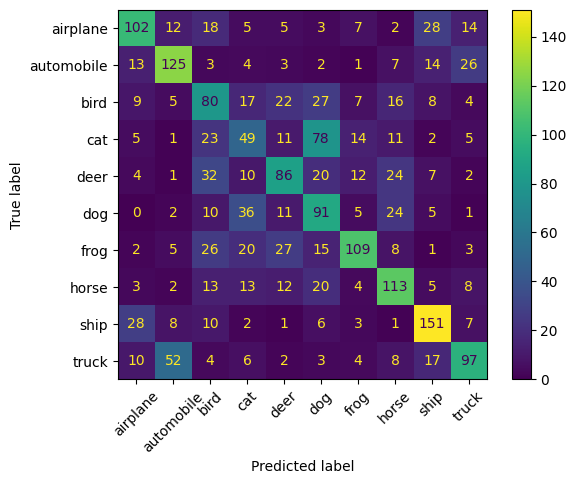

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features['label'].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)